# Завдання 1

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import skimage

In [ ]:
book_path = lambda x: "data/book/book_" + str(x) + ".jpg"
imgs = [book_path(i) for i in range(1, 6)]

In [5]:
PATH_METADATA = r"data/book/metadata.txt"

gt_values = []
for i, line in enumerate(open(PATH_METADATA, "r")):
  if i > 4: continue
  name, value = line.split(" - ")
  gt_values.append(float(value))

In [7]:
real_size = [7.5, 25, 17.5]

Formula for the filter was found here https://stackoverflow.com/questions/2545323/laplacian-of-gaussian-filter-use?rq=4 (code is unique tho)

In [8]:
def create_log_kernel(size, sigma):
    x, y = np.meshgrid(np.linspace(-size//2, size//2, size), 
                      np.linspace(-size//2, size//2, size))
    
    log_kernel = -(1/(np.pi*sigma**4)) * (1 - (x**2 + y**2)/(2*sigma**2)) * \
                 np.exp(-(x**2 + y**2)/(2*sigma**2))
    
    return log_kernel

In [19]:
def LoG(image, sigma=3):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel_size = int(6*sigma + 1)
    if kernel_size % 2 == 0:
        kernel_size += 1
    log_kernel = create_log_kernel(kernel_size, sigma)
    log = cv2.filter2D(gray, 5, kernel=log_kernel)
    return log 

In [34]:
def detect_corners(image):
    # Detect corners
    log = LoG(image)
    corners = cv2.cornerHarris(log, 2, 3, 0.04)
    corners = cv2.dilate(corners, None)
    # Threshold the corners
    image[corners > 0.01 * corners.max()] = [0, 0, 255]
    return image, corners

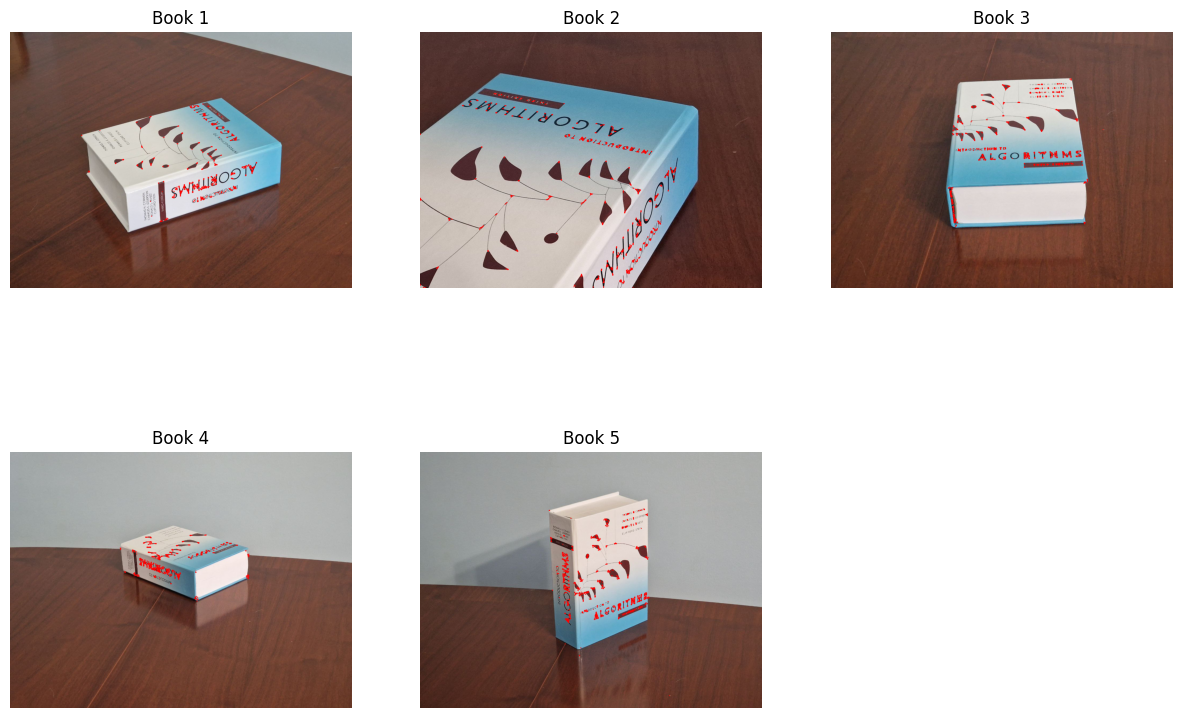

In [113]:
# drew corners on the images
plt.figure(figsize=(15, 10))
for i, img in enumerate(imgs):
    image = cv2.imread(img)
    image, corners = detect_corners(image)
    plt.subplot(2, 3, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Book {i+1}")
    plt.axis("off")

In [141]:
def extract_hog_features(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog = cv2.HOGDescriptor((64,128), (16,16), (8,8), (8,8), 9)
    resized = cv2.resize(gray, (64, 128))
    features = hog.compute(resized)
    features = features.reshape(-1, len(features))
    features = features.astype(np.float32)
    
    return features

In [164]:

def find_distances(reference_image, target_image, known_distance, real_size):
    # Знаходження ключових точок на зображеннях
    reference_features = extract_hog_features(reference_image)
    target_features = extract_hog_features(target_image)
    
    # Зіставлення ключових точок
    matcher = cv2.BFMatcher(cv2.NORM_L2)
    matches = matcher.match(reference_features, target_features)
    
    # Обчислення коефіцієнта пропорційності
    proportionality_coefficient = find_proportionality_coefficient(matches, reference_features, target_features)
    
    if proportionality_coefficient == 0 or np.isnan(proportionality_coefficient):
        return None
    
    distance = known_distance / proportionality_coefficient
    
    return distance

def find_proportionality_coefficient(good_matches, kp1, kp2):  
    distances1 = [np.linalg.norm(kp1[m.queryIdx] - kp1[n.queryIdx]) for m, n in zip(good_matches, good_matches[1:]) if np.linalg.norm(kp1[m.queryIdx] - kp1[n.queryIdx]) > 1e-8]
    distances2 = [np.linalg.norm(kp2[m.trainIdx] - kp2[n.trainIdx]) for m, n in zip(good_matches, good_matches[1:]) if np.linalg.norm(kp1[m.queryIdx] - kp1[n.queryIdx]) > 1e-8]
    
    if len(distances1) == 0 or len(distances2) == 0:
        return 0
    
    proportionality_coefficient = np.mean(np.array(distances2) / np.array(distances1))  
    return proportionality_coefficient

In [167]:
find_distances(cv2.imread(imgs[4]), cv2.imread(imgs[0]), 100, real_size)

# Завдання 2


In [93]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms

In [94]:
target_labels = [22, 37, 56]

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR100(root='./data', train=True, download=False, transform=transform)
testset = datasets.CIFAR100(root='./data', train=False, download=False, transform=transform)


In [97]:
def filter_data(dataset, target_labels):
    filtered_data = []
    for img, label in dataset:
        if label in target_labels:
            filtered_data.append((img, label))
    return filtered_data

In [98]:
filtered_trainset = filter_data(trainset, target_labels)
filtered_testset = filter_data(testset, target_labels)

In [99]:
remap = {22: 0, 37: 1, 56: 2}
remapped_trainset = [(img, remap[label]) for img, label in filtered_trainset]
remapped_testset = [(img, remap[label]) for img, label in filtered_testset]

In [100]:
trainloader = torch.utils.data.DataLoader(remapped_trainset, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(remapped_testset, batch_size=512, shuffle=False)

In [102]:
import torch.nn as nn
import torch.nn.functional as F

class RecognizeInator(nn.Module):
    def __init__(self, num_classes):
        super(RecognizeInator, self).__init__()
        

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)
        

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Self destruct button
        self.self_destruct_activated = False
        
    def forward(self, x):
        if self.self_destruct_activated:
            print("BABAH!")
            return None
            

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        

        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x
    
    def press_self_destruct_button(self):
        print("*Perry the Platypus presses the self-destruct button*")
        print("Boom!")
        self.self_destruct_activated = True

In [ ]:

from sklearn.metrics import roc_auc_score, f1_score  
import copy
import torch.optim as optim  

inator = RecognizeInator(3)    
num_epochs = 10 
  
train_losses, val_losses = [], [] 
train_accuracies, val_accuracies = [], []


criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(inator.parameters(), lr=0.001, momentum=0.9)  

In [111]:
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    
    # ===== Training Phase =====
    inator.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    
    for inputs, targets in trainloader:

        optimizer.zero_grad()
        outputs = inator(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        

        current_batch_size = inputs.size(0)
        running_loss += loss.item() * current_batch_size
        batch_predictions = outputs.max(1)[1]
        total += current_batch_size
        correct += batch_predictions.eq(targets).sum().item()
    

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # ===== Validation Phase =====
    inator.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions_collector = []
    targets_collector = []
    

    with torch.no_grad():
        for inputs, targets in testloader:

            outputs = inator(inputs)
            loss = criterion(outputs, targets)
            

            current_batch_size = inputs.size(0)
            running_loss += loss.item() * current_batch_size
            batch_predictions = outputs.max(1)[1]
            total += current_batch_size
            correct += batch_predictions.eq(targets).sum().item()


            predictions_collector.extend(outputs.cpu().numpy())
            targets_collector.extend(targets.cpu().numpy())

    val_loss = running_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    

    y_true = np.array(targets_collector)
    y_pred = np.argmax(np.array(predictions_collector), axis=1)
    f1 = f1_score(y_true, y_pred, average='weighted')
    

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
    print(f'Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
    print(f'F1 Score: {f1:.4f}\n')
    

    if val_acc > best_acc:
        best_acc = val_acc
        best_inator = copy.deepcopy(inator.state_dict())


inator.load_state_dict(best_inator)
torch.save(inator.state_dict(), 'best_inator.pth')

Epoch: 0
Epoch 1/10
Training - Loss: 0.5661, Accuracy: 0.7753
Validation - Loss: 0.6229, Accuracy: 0.7500
F1 Score: 0.7491

Epoch: 1
Epoch 2/10
Training - Loss: 0.5578, Accuracy: 0.7907
Validation - Loss: 0.6200, Accuracy: 0.7500
F1 Score: 0.7491

Epoch: 2
Epoch 3/10
Training - Loss: 0.5664, Accuracy: 0.7720
Validation - Loss: 0.6110, Accuracy: 0.7567
F1 Score: 0.7559

Epoch: 3
Epoch 4/10
Training - Loss: 0.5608, Accuracy: 0.7827
Validation - Loss: 0.6057, Accuracy: 0.7600
F1 Score: 0.7591

Epoch: 4
Epoch 5/10
Training - Loss: 0.5548, Accuracy: 0.7753
Validation - Loss: 0.5995, Accuracy: 0.7600
F1 Score: 0.7590

Epoch: 5
Epoch 6/10
Training - Loss: 0.5525, Accuracy: 0.7713
Validation - Loss: 0.5939, Accuracy: 0.7600
F1 Score: 0.7590

Epoch: 6
Epoch 7/10
Training - Loss: 0.5350, Accuracy: 0.7893
Validation - Loss: 0.5947, Accuracy: 0.7533
F1 Score: 0.7525

Epoch: 7
Epoch 8/10
Training - Loss: 0.5378, Accuracy: 0.7947
Validation - Loss: 0.5937, Accuracy: 0.7567
F1 Score: 0.7557

Epoch: 8

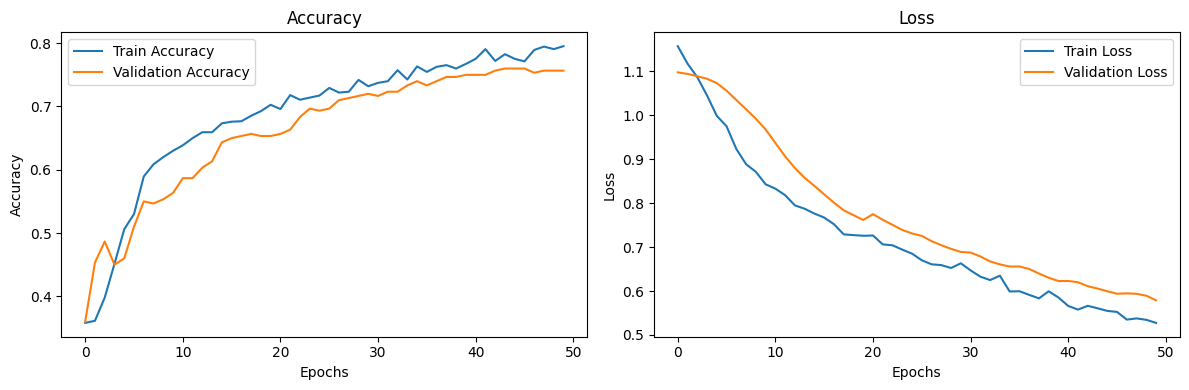

In [112]:
metrics_display = plt.figure(figsize=(12, 4))

accuracy_plot = plt.subplot(1, 2, 1)
accuracy_plot.plot(train_accuracies, label='Train Accuracy')
accuracy_plot.plot(val_accuracies, label='Validation Accuracy')
accuracy_plot.set_title('Accuracy')
accuracy_plot.set_xlabel('Epochs')
accuracy_plot.set_ylabel('Accuracy')
accuracy_plot.legend()

loss_plot = plt.subplot(1, 2, 2)
loss_plot.plot(train_losses, label='Train Loss')
loss_plot.plot(val_losses, label='Validation Loss')
loss_plot.set_title('Loss')
loss_plot.set_xlabel('Epochs')
loss_plot.set_ylabel('Loss')
loss_plot.legend()

plt.tight_layout()
plt.show()

In [134]:
import torchvision.models as models

class TransferInator(nn.Module):
    def __init__(self, num_classes, freeze_backbone=True):
        super(TransferInator, self).__init__()
        
        # Load pre-trained ResNet18
        self.backbone = models.resnet18(pretrained=True)
        
        # Freeze the backbone if specified
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Replace the final fully connected layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        self.self_destruct_activated = False
    
    def forward(self, x):
        if self.self_destruct_activated:
            print("BABAH!")
            return None
            
        return self.backbone(x)
    
    def press_self_destruct_button(self):
        print("*Perry the Platypus presses the self-destruct button*")
        self.self_destruct_activated = True
        
    def unfreeze_layers(self, num_layers=3):
        # Unfreeze the last few layers for fine-tuning
        modules = list(self.backbone.named_children())
        for name, module in modules[-num_layers:]:
            for param in module.parameters():
                param.requires_grad = True

In [139]:
# Model initialization
#transfer_inator = TransferInator(num_classes=len(target_labels), freeze_backbone=True)
#criterion = nn.CrossEntropyLoss()

# Training settings
num_initial_epochs = 5
num_finetune_epochs = 10
#train_losses, val_losses = [], []
#train_accuracies, val_accuracies = [], []
best_acc = 0.0

# Initial training phase
print("Phase 1: Training with frozen backbone")
optimizer = torch.optim.Adam([
    {'params': transfer_inator.backbone.fc.parameters(), 'lr': 1e-3},
    {'params': [p for n, p in transfer_inator.named_parameters() if 'fc' not in n], 'lr': 1e-4}
])

for epoch in range(num_initial_epochs):
    print(f"Epoch: {epoch}")
    
    transfer_inator.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in trainloader:
        inputs, targets = inputs, targets
        optimizer.zero_grad()
        outputs = transfer_inator(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        current_batch_size = inputs.size(0)
        running_loss += loss.item() * current_batch_size
        batch_predictions = outputs.max(1)[1]
        total += current_batch_size
        correct += batch_predictions.eq(targets).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    transfer_inator.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions_collector = []
    targets_collector = []
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs, targets
            outputs = transfer_inator(inputs)
            loss = criterion(outputs, targets)
            
            current_batch_size = inputs.size(0)
            running_loss += loss.item() * current_batch_size
            batch_predictions = outputs.max(1)[1]
            total += current_batch_size
            correct += batch_predictions.eq(targets).sum().item()
            
            predictions_collector.extend(outputs.cpu().numpy())
            targets_collector.extend(targets.cpu().numpy())
    
    val_loss = running_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    y_true = np.array(targets_collector)
    y_pred = np.argmax(np.array(predictions_collector), axis=1)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f'Epoch {epoch+1}/{num_initial_epochs}')
    print(f'Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
    print(f'Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
    print(f'F1 Score: {f1:.4f}\n')
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(transfer_inator.state_dict())

# Fine-tuning phase
print("\nPhase 2: Fine-tuning unfrozen layers")
transfer_inator.unfreeze_layers(num_layers=3)
optimizer = torch.optim.Adam(transfer_inator.parameters(), lr=1e-5)

for epoch in range(num_finetune_epochs):
    print(f"Epoch: {epoch}")
    
    transfer_inator.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in trainloader:
        inputs, targets = inputs, targets
        optimizer.zero_grad()
        outputs = transfer_inator(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        current_batch_size = inputs.size(0)
        running_loss += loss.item() * current_batch_size
        batch_predictions = outputs.max(1)[1]
        total += current_batch_size
        correct += batch_predictions.eq(targets).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    transfer_inator.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions_collector = []
    targets_collector = []
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs, targets
            outputs = transfer_inator(inputs)
            loss = criterion(outputs, targets)
            
            current_batch_size = inputs.size(0)
            running_loss += loss.item() * current_batch_size
            batch_predictions = outputs.max(1)[1]
            total += current_batch_size
            correct += batch_predictions.eq(targets).sum().item()
            
            predictions_collector.extend(outputs.cpu().numpy())
            targets_collector.extend(targets.cpu().numpy())
    
    val_loss = running_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    y_true = np.array(targets_collector)
    y_pred = np.argmax(np.array(predictions_collector), axis=1)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f'Epoch {epoch+1}/{num_finetune_epochs}')
    print(f'Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
    print(f'Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
    print(f'F1 Score: {f1:.4f}\n')
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(transfer_inator.state_dict())

# Load and save best model
transfer_inator.load_state_dict(best_model_wts)
torch.save(transfer_inator.state_dict(), 'best_transfer_inator_resnet.pth')

Phase 1: Training with frozen backbone
Epoch: 0
Epoch 1/5
Training - Loss: 0.3955, Accuracy: 0.8413
Validation - Loss: 0.4935, Accuracy: 0.8267
F1 Score: 0.8268

Epoch: 1
Epoch 2/5
Training - Loss: 0.2337, Accuracy: 0.9193
Validation - Loss: 0.5493, Accuracy: 0.7933
F1 Score: 0.7956

Epoch: 2
Epoch 3/5
Training - Loss: 0.1550, Accuracy: 0.9527
Validation - Loss: 0.5052, Accuracy: 0.8267
F1 Score: 0.8263

Epoch: 3
Epoch 4/5
Training - Loss: 0.0931, Accuracy: 0.9733
Validation - Loss: 0.5599, Accuracy: 0.8233
F1 Score: 0.8240

Epoch: 4
Epoch 5/5
Training - Loss: 0.0420, Accuracy: 0.9880
Validation - Loss: 0.6636, Accuracy: 0.8233
F1 Score: 0.8253


Phase 2: Fine-tuning unfrozen layers
Epoch: 0
Epoch 1/10
Training - Loss: 0.0347, Accuracy: 0.9920
Validation - Loss: 0.7002, Accuracy: 0.8167
F1 Score: 0.8188

Epoch: 1
Epoch 2/10
Training - Loss: 0.0250, Accuracy: 0.9967
Validation - Loss: 0.7216, Accuracy: 0.8167
F1 Score: 0.8186

Epoch: 2
Epoch 3/10
Training - Loss: 0.0224, Accuracy: 0.996

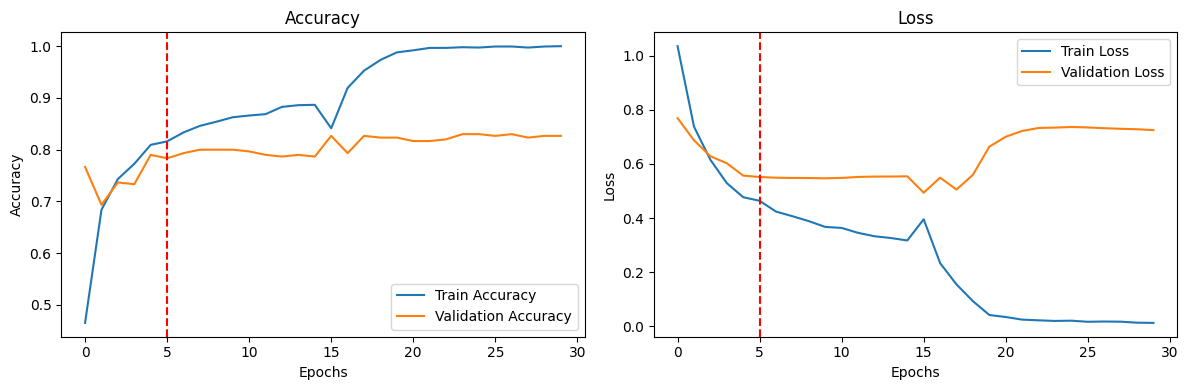

In [140]:
metrics_display = plt.figure(figsize=(12, 4))

accuracy_plot = plt.subplot(1, 2, 1)
accuracy_plot.plot(train_accuracies, label='Train Accuracy')
accuracy_plot.plot(val_accuracies, label='Validation Accuracy')
accuracy_plot.set_title('Accuracy')
accuracy_plot.set_xlabel('Epochs')
accuracy_plot.set_ylabel('Accuracy')
accuracy_plot.legend()
accuracy_plot.axvline(x=num_initial_epochs, color='r', linestyle='--', label='Start Fine-tuning')

loss_plot = plt.subplot(1, 2, 2)
loss_plot.plot(train_losses, label='Train Loss')
loss_plot.plot(val_losses, label='Validation Loss')
loss_plot.set_title('Loss')
loss_plot.set_xlabel('Epochs')
loss_plot.set_ylabel('Loss')
loss_plot.legend()
loss_plot.axvline(x=num_initial_epochs, color='r', linestyle='--', label='Start Fine-tuning')

plt.tight_layout()
plt.show()